# Summary

Historical data in this file is from the period 2020-12-20 to 2025-08-31.

Strategies with strong results:
  - Strategy 4: Rank-Threshold Simple One-Period (4h) Reversal Signal
  - Strategy 8: Use Raw One-Period (4h) Reversal Signal (Don't Rank But Do Demean-Normalize)
  - Strategy 9: Multiple-Period Reversal Signal Traded Every Period
  - Strategy 10: Winsorize Un-ranked Demean-Normalized Reversal Signal -- winsorize top and bottom 2%, top and bottom 5%

Strategies with okay results:
  - Strategy 6: One-Period (4h) Reversal Signal Traded Less Frequently Than One Period -- use 8h frequency
  - Strategy 7: Multiple-Period Reversal Signal Traded Less Frequently Than One Period -- use 8h frequency, use 12h frequency offset by 8h, 24h frequency
  - Strategy 10: Winsorize Un-ranked Demean-Normalized Reversal Signal -- winsorize top and bottom 10%

All strategies:
  - Strategy 1: Simple One-Period (4h) Reversal Signal
  - Strategy 2: Winsorize Simple One-Period (4h) Reversal Signal
  - Strategy 3: Truncate Simple One-Period (4h) Reversal Signal¶
  - Strategy 4: Rank-Threshold Simple One-Period (4h) Reversal Signal
  - Strategy 5: Inverse CDF Of Simple One-Period (4h) Reversal Signal: Rank, Inverse CDF Then Demean-Normalize
  - Strategy 6: One-Period (4h) Reversal Signal Traded Less Frequently Than One Period
  - Strategy 7: Multiple-Period Reversal Signal Traded Less Frequently Than One Period
  - Strategy 8: Use Raw One-Period (4h) Reversal Signal (Don't Rank But Do Demean-Normalize)
  - Strategy 9: Multiple-Period Reversal Signal Traded Every Period
  - Strategy 10: Winsorize Un-ranked Demean-Normalized Reversal Signal
  - Strategy 11: Truncate Un-ranked Demean-Normalized Reversal Signal
  - Strategy 12: Rank-Threshold Un-ranked Demean-Normalized Reversal Signal
  - Strategy 13: Inverse CDF Of Un-ranked Reversal Signal, Then Demean-Normalize
  - Strategy 14: Inverse CDF Of Un-ranked Reversal Signal, Then Rank-Demean-Normalize
  - Strategy 15: Multiple-Period Momentum Signal Traded Less Frequently Than One Period
  - Strategy 16: Use Rolling Average Of Simple One-Period (4h) Reversal Signal
  - Strategy 17: Use Exponential Decay Of Simple One-Period (4h) Reversal Signal

# Imports

In [14]:
import pandas as pd
import numpy as np

from datetime import timedelta
from scipy.stats.mstats import winsorize
from scipy.stats import norm
from binance.client import Client as bnb_client
from datetime import datetime

from ipynb.fs.full.utility_functions import (
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    get_strategy_stats,
    get_decorrelated_returns,
)

# Get Historical Data For Cryptocurrencies

In [7]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [8]:
client = bnb_client(tld='US')


def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Utility Methods

In [13]:
bitcoin_benchmark_returns = px['BTCUSDT'] / px['BTCUSDT'].shift() - 1


def get_bitcoin_returns_over_period(input_prices, trade_hours_freq = 4):
    date_times = []
    current_date_time = input_prices.index[0]
    while current_date_time <= input_prices.index[-1]:
        if current_date_time in input_prices.index:
            date_times.append(current_date_time)
        current_date_time += timedelta(hours=trade_hours_freq)
    btc_prices_at_interval = input_prices['BTCUSDT'].loc[date_times]
    return btc_prices_at_interval / btc_prices_at_interval.shift() - 1


# For example, proportion_lo = 0.1 and proportion_hi = 0.1 makes the top and bottom 10% be the values at the
# 90th and 10th percentiles, respectively.
def get_winsorized_signal(raw_signal, proportion_lo, proportion_hi):
    winsorized_signal = raw_signal.apply(lambda row: winsorize(
        row, limits=[proportion_lo, proportion_hi]), axis=1, result_type='expand')
    winsorized_signal.columns = raw_signal.columns
    return winsorized_signal


# For example, proportion_lo = 0.1 and proportion_hi = 0.1 makes the top and bottom 10% be removed.
def get_truncated_signal(raw_signal, proportion_lo, proportion_hi):
    quantile_lo = raw_signal.quantile(proportion_lo, axis=1)
    mask_lo = raw_signal.lt(quantile_lo, axis=0)

    quantile_hi = raw_signal.quantile(1-proportion_hi, axis=1)
    mask_hi = raw_signal.gt(quantile_hi, axis=0)

    return raw_signal.mask(mask_lo).mask(mask_hi)


# For example, proportion_lo = 0.1 and proportion_hi = 0.1 makes the middle 80% of the data be removed.
def get_rank_thresholded_signal(raw_signal, proportion_lo, proportion_hi):
    quantile_lo = raw_signal.quantile(proportion_lo, axis=1)
    mask_above = raw_signal.gt(quantile_lo, axis=0)

    quantile_hi = raw_signal.quantile(1-proportion_hi, axis=1)
    mask_below = raw_signal.lt(quantile_hi, axis=0)
    
    return raw_signal.mask(mask_above & mask_below)


def get_inverse_cdf_standard_normal_signal(raw_signal):
    ranked_signal = raw_signal.rank(axis=1)
    num_non_na = ranked_signal.notna().astype(int).sum(axis=1)

    return pd.DataFrame(
        norm.ppf(ranked_signal.divide(num_non_na + 1, axis=0)),
        columns=raw_signal.columns,
        index=raw_signal.index)


def get_demeaned_normalized_signal(raw_signal):
    signal_mean = raw_signal.mean(axis=1)
    demeaned_signal = raw_signal.subtract(signal_mean, axis=0)
    signal_sums = demeaned_signal.abs().sum(axis=1)
    return demeaned_signal.divide(signal_sums, axis=0)

# Strategy 1: Simple One-Period (4h) Reversal Signal 

In [34]:
ret = px / px.shift() - 1
simple_raw_reversal_signal = ret * -1
simple_raw_reversal_signal

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 04:00:00,-0.010716,-0.013315,-0.021739,-0.020863,-0.017069,NaN,NaN,-0.033748,-0.084668,NaN,...,NaN,-0.004230,NaN,NaN,NaN,0.006019,NaN,-0.014607,NaN,NaN
2020-12-20 08:00:00,0.002319,0.003587,0.010518,-0.034671,-0.000553,NaN,NaN,0.026463,-0.028529,NaN,...,NaN,-0.010738,NaN,NaN,NaN,-0.000000,NaN,-0.007803,NaN,NaN
2020-12-20 12:00:00,-0.014070,-0.000551,-0.004799,-0.005433,0.002589,NaN,NaN,-0.008553,-0.032914,NaN,...,NaN,0.013320,NaN,NaN,NaN,-0.022608,NaN,-0.019803,NaN,NaN
2020-12-20 16:00:00,-0.002172,0.005235,0.002418,0.008791,0.008512,NaN,NaN,0.020991,0.011406,NaN,...,NaN,0.005466,NaN,NaN,NaN,0.011844,NaN,0.027506,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,-0.000563,0.005439,0.003769,0.002863,0.000178,-0.007924,NaN,0.003526,0.005505,0.002136,...,0.069320,-0.000000,-0.003623,-0.000000,-0.0,-0.000000,-0.000000,NaN,NaN,-0.000000
2025-08-30 20:00:00,0.003231,-0.005161,-0.002685,-0.006840,-0.004346,0.011268,NaN,-0.004899,-0.020111,-0.004709,...,-0.000000,-0.000000,0.087846,-0.000000,-0.0,-0.000000,-0.000000,NaN,NaN,-0.000000
2025-08-31 00:00:00,-0.005397,-0.025655,-0.017281,-0.001009,-0.011492,-0.024914,NaN,-0.008125,0.002894,-0.018321,...,-0.053793,-0.000000,-0.003298,-0.022676,-0.0,-0.000000,-0.037928,NaN,NaN,-0.056136


<Axes: xlabel='open_time'>

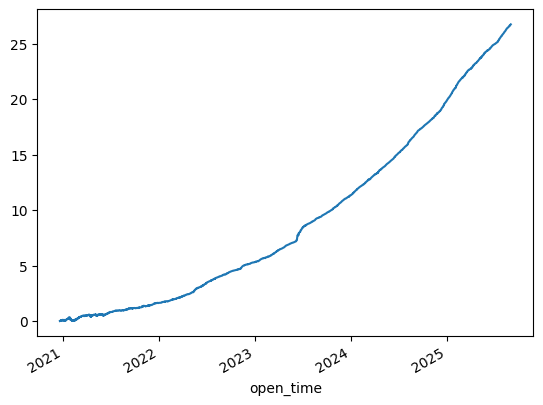

In [35]:
transformed_signal = get_rank_demeaned_normalized_signal(simple_raw_reversal_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)

gross_returns.cumsum().plot()

<Axes: title={'center': 'Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns'}, xlabel='open_time'>

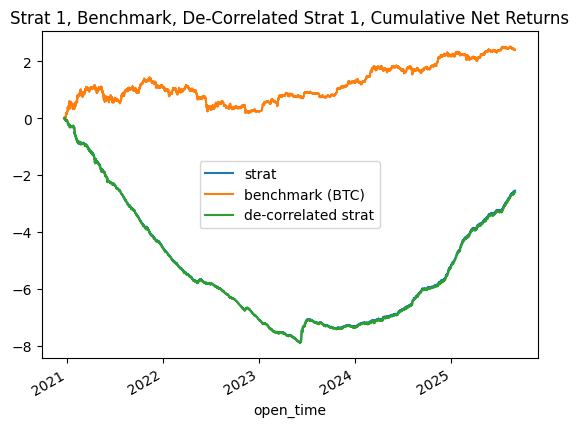

In [36]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns")

The strategy is heavily de-correlated from the benchmark of bitcoin (BTCUSDT) already so the line for the strategy (the blue line) is covered by the line for the de-correlated strategy (the green line).

In [37]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -0.5417910961191515,
 'volatility': 0.2637606139161894,
 'sharpe ratio': -2.0541015888418697,
 'max drawdown': -2252.7514939157913,
 'max drawdown duration': 1713.0,
 'alpha_BTC': -0.000252048558979096,
 'beta_BTC': 0.020664750027787906}

# Strategy 2: Winsorize Simple One-Period (4h) Reversal Signal

In [38]:
ret = px / px.shift() - 1
raw_signal = ret * -1

### With limits of 10% on each side

In [39]:
winsorized_signal_10 = get_winsorized_signal(raw_signal, 0.1, 0.1)
winsorized_signal_10

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 04:00:00,-0.010716,-0.013315,-0.020863,-0.020863,-0.017069,NaN,NaN,-0.020863,-0.020863,NaN,...,NaN,-0.004230,NaN,NaN,NaN,0.006019,NaN,-0.014607,NaN,NaN
2020-12-20 08:00:00,0.002319,0.003587,0.010518,-0.007803,-0.000553,NaN,NaN,0.026463,-0.007803,NaN,...,NaN,-0.007803,NaN,NaN,NaN,-0.000000,NaN,-0.007803,NaN,NaN
2020-12-20 12:00:00,-0.014070,-0.000551,-0.004799,-0.005433,0.002589,NaN,NaN,-0.008553,-0.014172,NaN,...,NaN,0.013320,NaN,NaN,NaN,-0.014172,NaN,-0.014172,NaN,NaN
2020-12-20 16:00:00,0.003950,0.005235,0.003950,0.008791,0.008512,NaN,NaN,0.020991,0.011406,NaN,...,NaN,0.005466,NaN,NaN,NaN,0.011844,NaN,0.027506,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,-0.000563,0.005439,0.003769,0.002863,0.000178,-0.003310,NaN,0.003526,0.005505,0.002136,...,0.069320,-0.000000,-0.003310,-0.000000,-0.0,-0.000000,-0.000000,NaN,NaN,-0.000000
2025-08-30 20:00:00,0.003231,-0.005161,-0.002685,-0.006840,-0.004346,0.011268,NaN,-0.004899,-0.010767,-0.004709,...,-0.000000,-0.000000,0.087846,-0.000000,-0.0,-0.000000,-0.000000,NaN,NaN,-0.000000
2025-08-31 00:00:00,-0.005397,-0.025655,-0.017281,-0.001009,-0.011492,-0.024914,NaN,-0.008125,0.002894,-0.018321,...,-0.045067,-0.000000,-0.003298,-0.022676,-0.0,-0.000000,-0.037928,NaN,NaN,-0.045067


<Axes: >

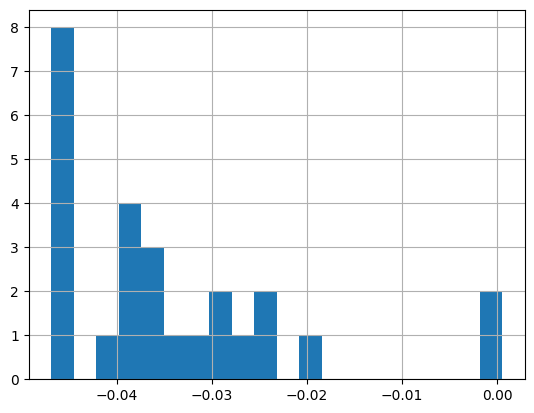

In [40]:
winsorized_signal_10.iloc[200].hist(bins=20)

In [41]:
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal_10)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.005209
2020-12-20 12:00:00   -0.004331
2020-12-20 16:00:00   -0.000546
                         ...   
2025-08-30 16:00:00    0.002794
2025-08-30 20:00:00    0.001231
2025-08-31 00:00:00    0.001694
2025-08-31 04:00:00    0.001376
2025-08-31 08:00:00   -0.004966
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 2, Upper And Lower 10% Winsorized, \nCumulative Gross Returns'}, xlabel='open_time'>

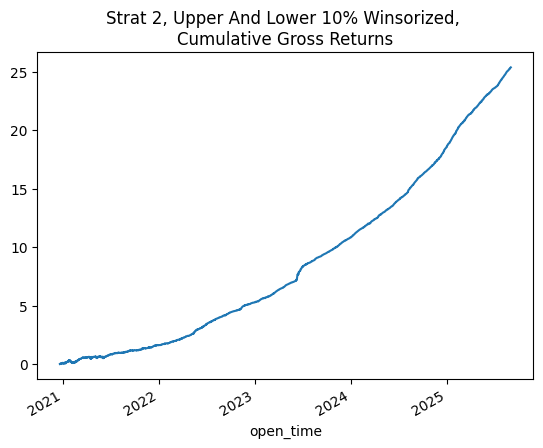

In [42]:
gross_returns.cumsum().plot(title = "Strat 2, Upper And Lower 10% Winsorized, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 2, Upper And Lower 10% Winsorized,\n Benchmark, De-Correlated Strat 2, \nCumulative Net Returns'}, xlabel='open_time'>

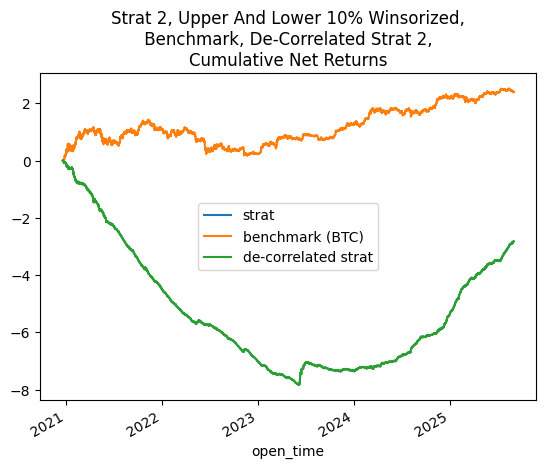

In [43]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 2, Upper And Lower 10% Winsorized,\n Benchmark, De-Correlated Strat 2, \nCumulative Net Returns")

In [44]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -0.5991416410969319,
 'volatility': 0.25168019337552155,
 'sharpe ratio': -2.3805673106861356,
 'max drawdown': -1872.3806295420725,
 'max drawdown duration': 1713.0,
 'alpha_BTC': -0.0002738932609742933,
 'beta_BTC': 0.0019530313411737664}

### With limits of 20% on each side

In [45]:
winsorized_signal_20 = get_winsorized_signal(raw_signal, 0.2, 0.2)

<Axes: >

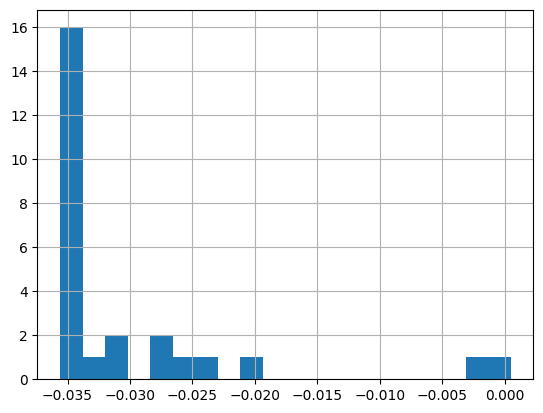

In [46]:
winsorized_signal_20.iloc[200].hist(bins=20)

In [47]:
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal_20)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.005012
2020-12-20 12:00:00   -0.003288
2020-12-20 16:00:00   -0.000033
                         ...   
2025-08-30 16:00:00    0.002715
2025-08-30 20:00:00   -0.000254
2025-08-31 00:00:00   -0.003713
2025-08-31 04:00:00    0.002308
2025-08-31 08:00:00   -0.002980
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 2, Winsorize Top And Bottom 20%, \nGross Cumulative Returns'}, xlabel='open_time'>

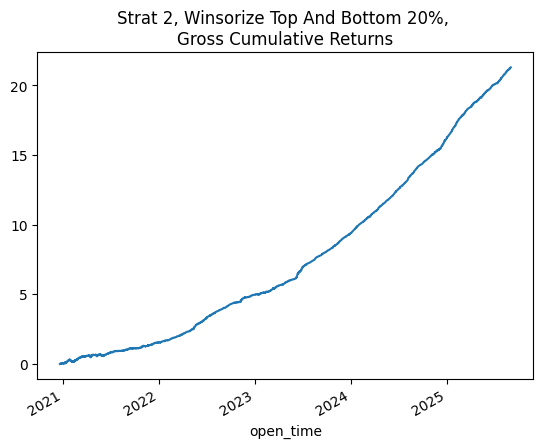

In [50]:
gross_returns.cumsum().plot(title = "Strat 2, Winsorize Top And Bottom 20%, \nGross Cumulative Returns")

<Axes: title={'center': 'Strat 2, Winsorize Top And Bottom 20%, \nBenchmark, De-Correlated Strat 2, Cumulative Net Returns'}, xlabel='open_time'>

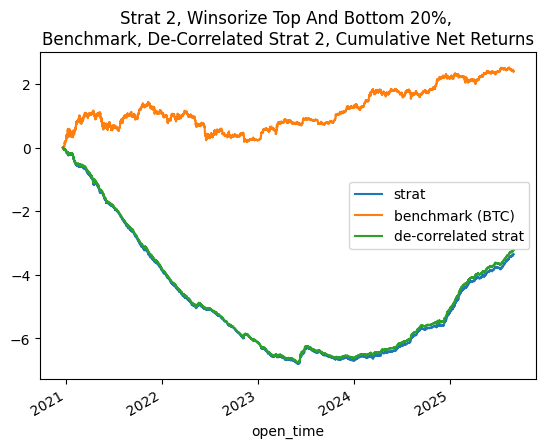

In [52]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 2, Winsorize Top And Bottom 20%, \nBenchmark, De-Correlated Strat 2, Cumulative Net Returns")

In [53]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -0.7135629472369659,
 'volatility': 0.22185812381942818,
 'sharpe ratio': -3.2163029910851475,
 'max drawdown': -1291.186159727889,
 'max drawdown duration': 1714.1666666666667,
 'alpha_BTC': -0.00031304563209253307,
 'beta_BTC': -0.05444637446100386}

# Strategy 3: Truncate Simple One-Period (4h) Reversal Signal

In [54]:
ret = px / px.shift() - 1
raw_signal = ret * -1

### Truncate top and bottom 2%

In [55]:
truncated_signal = get_truncated_signal(raw_signal, 0.02, 0.02)

In [56]:
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.008513
2020-12-20 12:00:00   -0.003174
2020-12-20 16:00:00   -0.002331
                         ...   
2025-08-30 16:00:00    0.000388
2025-08-30 20:00:00   -0.000223
2025-08-31 00:00:00    0.003503
2025-08-31 04:00:00    0.001613
2025-08-31 08:00:00   -0.004087
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 2%, \nCumulative Gross Returns'}, xlabel='open_time'>

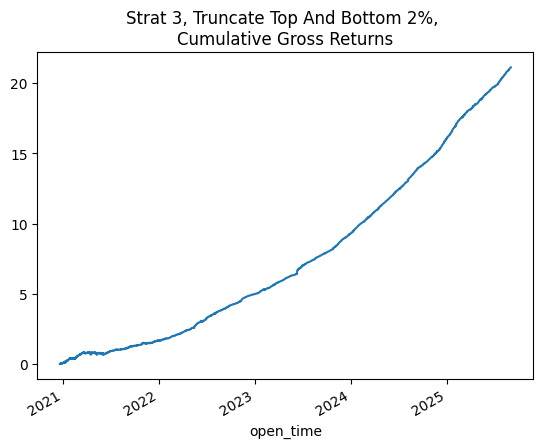

In [59]:
gross_returns.cumsum().plot(title = "Strat 3, Truncate Top And Bottom 2%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 2%, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns'}, xlabel='open_time'>

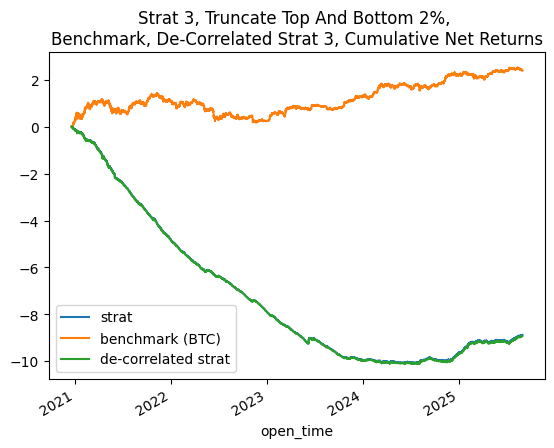

In [60]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 3, Truncate Top And Bottom 2%, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns")

In [61]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -1.8875203317937959,
 'volatility': 0.22289183891152073,
 'sharpe ratio': -8.468324102898478,
 'max drawdown': -1046.770683010125,
 'max drawdown duration': 1712.6666666666667,
 'alpha_BTC': -0.0008662856653092653,
 'beta_BTC': 0.019069918430511208}

### Truncate top and bottom 5%

In [62]:
truncated_signal = get_truncated_signal(raw_signal, 0.05, 0.05)

In [63]:
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.008163
2020-12-20 12:00:00   -0.003596
2020-12-20 16:00:00   -0.002719
                         ...   
2025-08-30 16:00:00   -0.001140
2025-08-30 20:00:00    0.001623
2025-08-31 00:00:00    0.002691
2025-08-31 04:00:00    0.002246
2025-08-31 08:00:00   -0.004314
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 5%, \nGross Cumulative Returns'}, xlabel='open_time'>

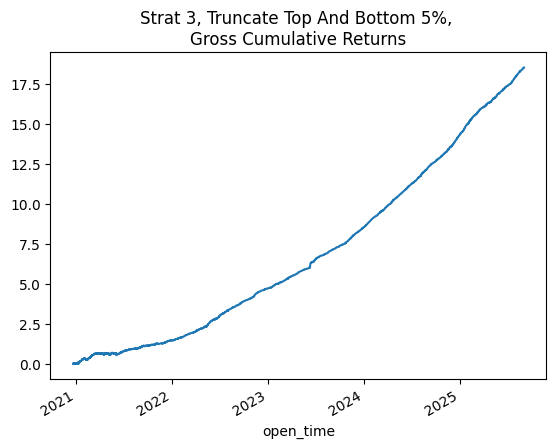

In [66]:
gross_returns.cumsum().plot(title="Strat 3, Truncate Top And Bottom 5%, \nGross Cumulative Returns")

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 5%, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns'}, xlabel='open_time'>

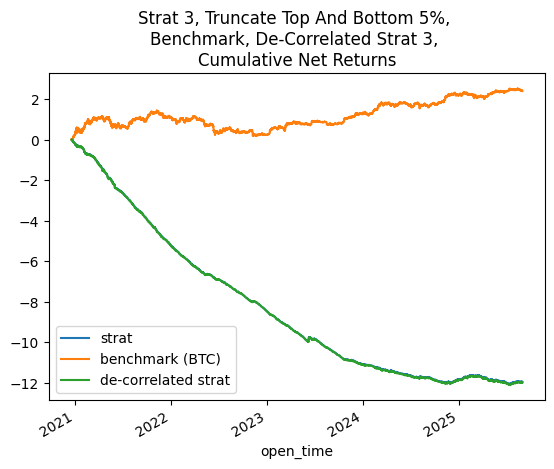

In [68]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 3, Truncate Top And Bottom 5%, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns")

In [69]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -2.5406752904476027,
 'volatility': 0.21734183061906295,
 'sharpe ratio': -11.689766683251452,
 'max drawdown': -1284.3898937271772,
 'max drawdown duration': 1714.0,
 'alpha_BTC': -0.0011640201644547803,
 'beta_BTC': 0.016626520078666624}

### Truncate top and bottom 10%

In [70]:
truncated_signal = get_truncated_signal(raw_signal, 0.1, 0.1)

In [71]:
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.011378
2020-12-20 12:00:00   -0.003007
2020-12-20 16:00:00   -0.001665
                         ...   
2025-08-30 16:00:00   -0.001659
2025-08-30 20:00:00   -0.002100
2025-08-31 00:00:00    0.000316
2025-08-31 04:00:00    0.002444
2025-08-31 08:00:00   -0.005036
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 10%, \nCumulative Gross Returns'}, xlabel='open_time'>

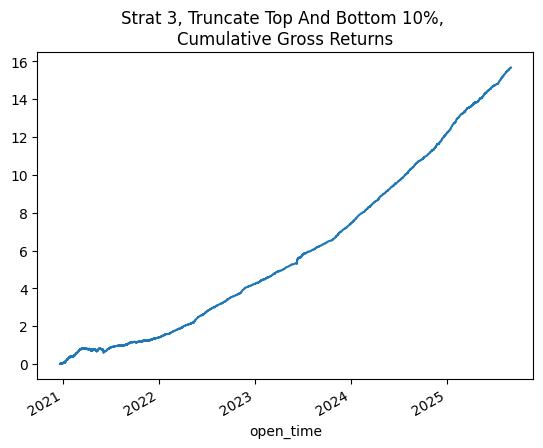

In [72]:
gross_returns.cumsum().plot(title="Strat 3, Truncate Top And Bottom 10%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 10%, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns'}, xlabel='open_time'>

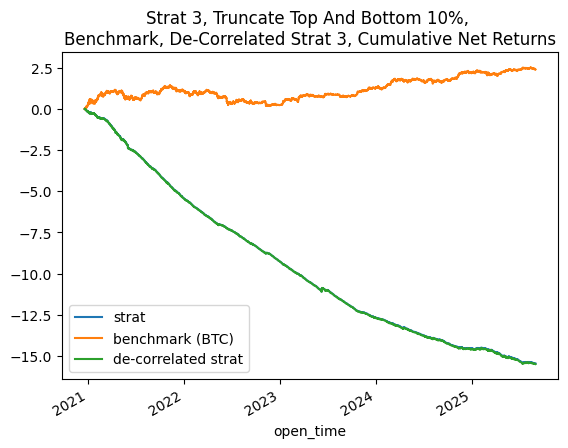

In [73]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 3, Truncate Top And Bottom 10%, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns")

In [74]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -3.2884305621402614,
 'volatility': 0.22306134685455964,
 'sharpe ratio': -14.742269821783072,
 'max drawdown': -1040.0631471076124,
 'max drawdown duration': 1714.0,
 'alpha_BTC': -0.0015052871168824758,
 'beta_BTC': 0.015592860533197899}

### Truncate top and bottom 20%

In [75]:
truncated_signal = get_truncated_signal(raw_signal, 0.2, 0.2)

In [76]:
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00   -0.003592
2020-12-20 12:00:00   -0.003317
2020-12-20 16:00:00   -0.001082
                         ...   
2025-08-30 16:00:00   -0.002325
2025-08-30 20:00:00   -0.001595
2025-08-31 00:00:00   -0.000541
2025-08-31 04:00:00    0.000807
2025-08-31 08:00:00   -0.003870
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 20%, \nCumulative Gross Returns'}, xlabel='open_time'>

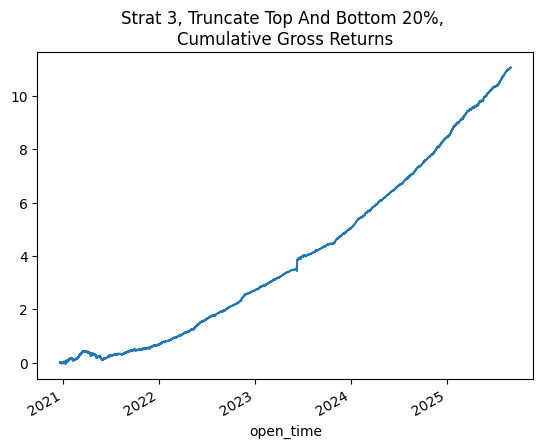

In [78]:
gross_returns.cumsum().plot(title="Strat 3, Truncate Top And Bottom 20%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 3, Truncate Top And Bottom 20%, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns'}, xlabel='open_time'>

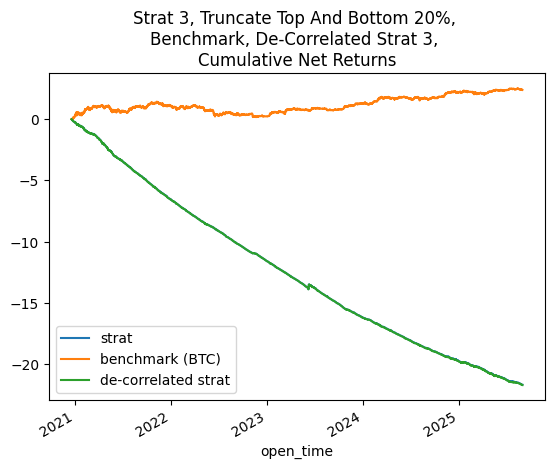

In [80]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 3, Truncate Top And Bottom 20%, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns")

In [81]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -4.613967098266714,
 'volatility': 0.2380324873159387,
 'sharpe ratio': -19.38377046887146,
 'max drawdown': nan,
 'max drawdown duration': 1715.0,
 'alpha_BTC': -0.0021096606581416243,
 'beta_BTC': 0.011237818521772356}

# Strategy 4: Rank-Threshold Simple One-Period (4h) Reversal Signal

In [82]:
ret = px / px.shift() - 1
raw_signal = ret * -1

### Rank-threshold top and bottom 20%

In [83]:
rank_thresholded_signal = get_rank_thresholded_signal(raw_signal, 0.2, 0.2)

In [84]:
transformed_signal = get_rank_demeaned_normalized_signal(rank_thresholded_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.005682
2020-12-20 12:00:00   -0.006909
2020-12-20 16:00:00    0.000958
                         ...   
2025-08-30 16:00:00    0.008306
2025-08-30 20:00:00    0.001972
2025-08-31 00:00:00    0.001854
2025-08-31 04:00:00    0.001235
2025-08-31 08:00:00   -0.005674
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 20%,\n Cumulative Gross Returns'}, xlabel='open_time'>

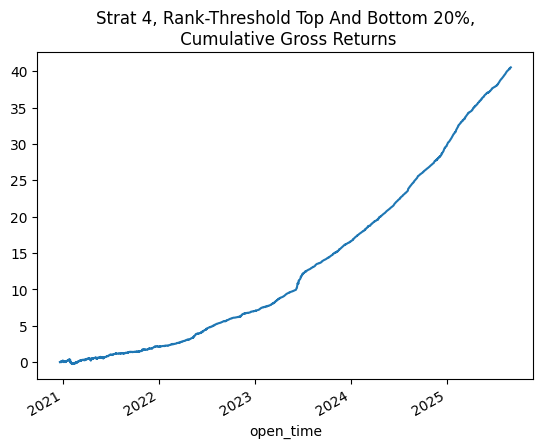

In [85]:
gross_returns.cumsum().plot(title="Strat 4, Rank-Threshold Top And Bottom 20%,\n Cumulative Gross Returns")

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 20%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns'}, xlabel='open_time'>

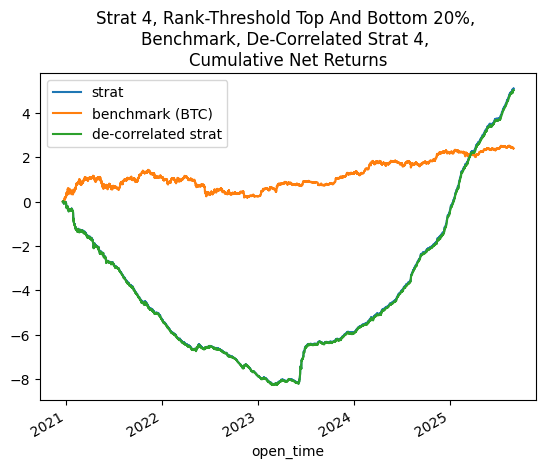

In [87]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 4, Rank-Threshold Top And Bottom 20%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns")

In [88]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 1.0857968253558516,
 'volatility': 0.4550933395769632,
 'sharpe ratio': 2.385877205685246,
 'max drawdown': -820.0710230143179,
 'max drawdown duration': 1483.0,
 'alpha_BTC': 0.0004897494041158383,
 'beta_BTC': 0.027280918509055428}

### Rank-threshold top and bottom 10%

In [89]:
rank_thresholded_signal = get_rank_thresholded_signal(raw_signal, 0.1, 0.1)

In [90]:
transformed_signal = get_rank_demeaned_normalized_signal(rank_thresholded_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00   -0.006608
2020-12-20 12:00:00   -0.010079
2020-12-20 16:00:00    0.004580
                         ...   
2025-08-30 16:00:00    0.015151
2025-08-30 20:00:00    0.000669
2025-08-31 00:00:00   -0.002035
2025-08-31 04:00:00   -0.001132
2025-08-31 08:00:00   -0.005019
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 10%, \nCumulative Gross Returns'}, xlabel='open_time'>

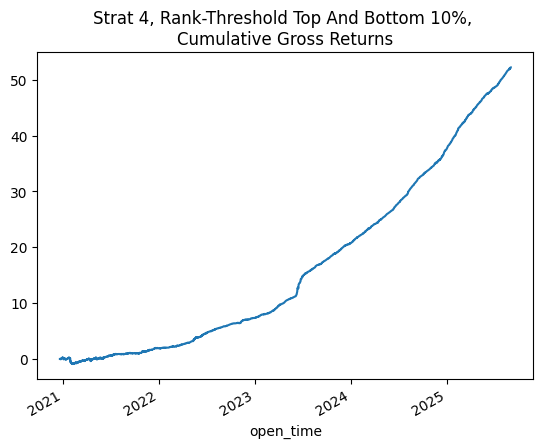

In [91]:
gross_returns.cumsum().plot(title="Strat 4, Rank-Threshold Top And Bottom 10%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 10%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns'}, xlabel='open_time'>

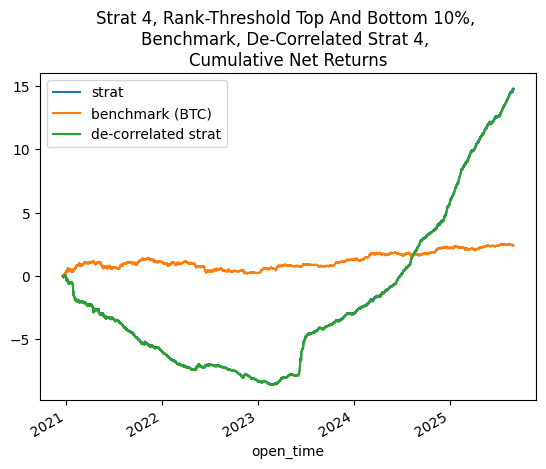

In [95]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 4, Rank-Threshold Top And Bottom 10%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns")

In [96]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 3.1537162400103176,
 'volatility': 0.7213817283766352,
 'sharpe ratio': 4.3717717207882405,
 'max drawdown': -164.759021909569,
 'max drawdown duration': 1274.0,
 'alpha_BTC': 0.0014331319045670355,
 'beta_BTC': 0.03182768807866388}

### Rank-threshold top and bottom 5%

In [97]:
rank_thresholded_signal = get_rank_thresholded_signal(raw_signal, 0.05, 0.05)

In [98]:
transformed_signal = get_rank_demeaned_normalized_signal(rank_thresholded_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00   -0.009609
2020-12-20 12:00:00   -0.012388
2020-12-20 16:00:00    0.008188
                         ...   
2025-08-30 16:00:00    0.019025
2025-08-30 20:00:00    0.001625
2025-08-31 00:00:00   -0.009624
2025-08-31 04:00:00   -0.003336
2025-08-31 08:00:00   -0.008617
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 5%, \nCumulative Gross Returns'}, xlabel='open_time'>

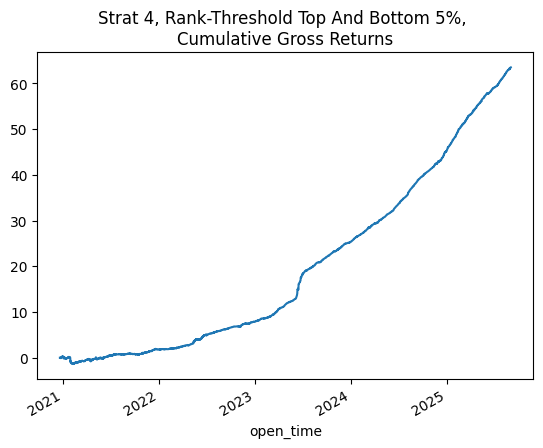

In [99]:
gross_returns.cumsum().plot(title="Strat 4, Rank-Threshold Top And Bottom 5%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 5%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns'}, xlabel='open_time'>

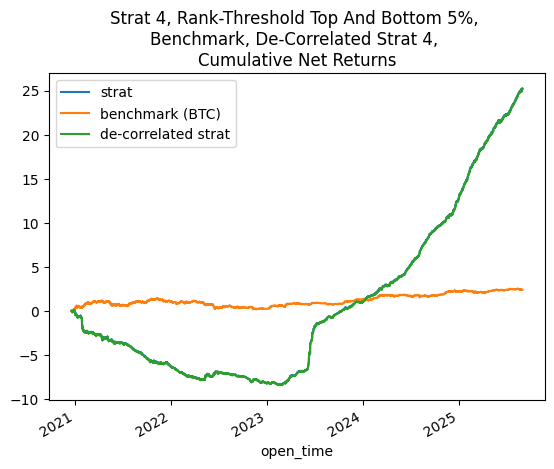

In [100]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 4, Rank-Threshold Top And Bottom 5%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns")

In [101]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 5.368555024456785,
 'volatility': 1.053873505491951,
 'sharpe ratio': 5.094117079972258,
 'max drawdown': -99.93311164126405,
 'max drawdown duration': 1018.8333333333334,
 'alpha_BTC': 0.0024434230189282007,
 'beta_BTC': 0.0371960141851372}

### Rank-threshold top and bottom 2%

In [94]:
rank_thresholded_signal = get_rank_thresholded_signal(raw_signal, 0.02, 0.02)

In [95]:
transformed_signal = get_rank_demeaned_normalized_signal(rank_thresholded_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00   -0.015849
2020-12-20 12:00:00   -0.015621
2020-12-20 16:00:00    0.011261
                         ...   
2025-08-30 16:00:00    0.016650
2025-08-30 20:00:00    0.001945
2025-08-31 00:00:00   -0.018967
2025-08-31 04:00:00   -0.006797
2025-08-31 08:00:00   -0.012376
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 2%, \nCumulative Gross Returns'}, xlabel='open_time'>

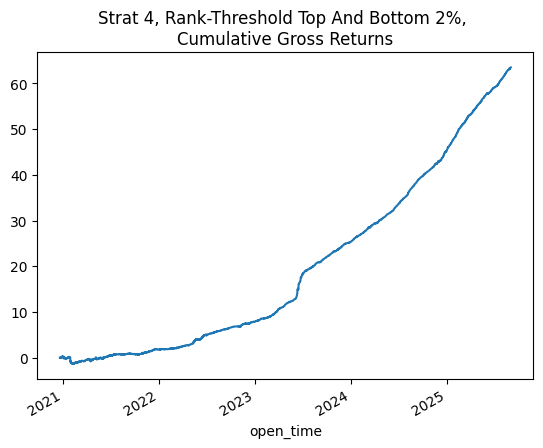

In [103]:
gross_returns.cumsum().plot(title="Strat 4, Rank-Threshold Top And Bottom 2%, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 4, Rank-Threshold Top And Bottom 2%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns'}, xlabel='open_time'>

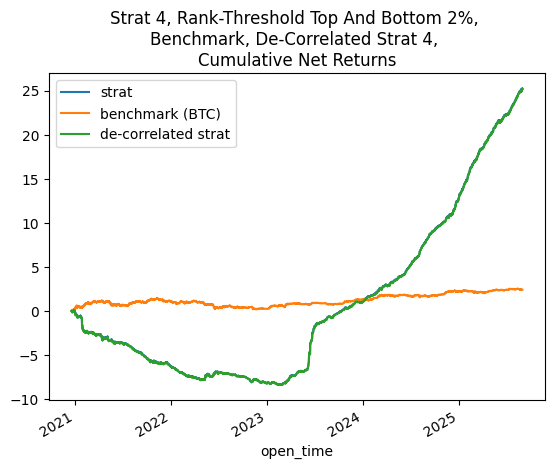

In [104]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 4, Rank-Threshold Top And Bottom 2%, \nBenchmark, De-Correlated Strat 4, \nCumulative Net Returns")

In [105]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 5.368555024456785,
 'volatility': 1.053873505491951,
 'sharpe ratio': 5.094117079972258,
 'max drawdown': -99.93311164126405,
 'max drawdown duration': 1018.8333333333334,
 'alpha_BTC': 0.0024434230189282007,
 'beta_BTC': 0.0371960141851372}

In [106]:
last_row = transformed_signal.iloc[-1]
last_row[last_row.notna()]

DASHUSDT    0.03125
YFIUSDT     0.21875
MKRUSDT    -0.21875
ONTUSDT     0.15625
ALGOUSDT   -0.03125
EGLDUSDT   -0.15625
QTUMUSDT    0.09375
LRCUSDT    -0.09375
Name: 2025-08-31 08:00:00, dtype: float64

# Strategy 5: Inverse CDF Of Simple One-Period (4h) Reversal Signal: Rank, Inverse CDF Then Demean-Normalize

Use inverse standard normal distribution.

In [107]:
ret = px / px.shift() - 1
raw_signal = ret * -1

inverse_cdf_signal = get_inverse_cdf_standard_normal_signal(raw_signal)
transformed_signal = get_demeaned_normalized_signal(inverse_cdf_signal)

In [108]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00   -0.002000
2020-12-20 08:00:00    0.004680
2020-12-20 12:00:00   -0.005445
2020-12-20 16:00:00    0.000027
                         ...   
2025-08-30 16:00:00    0.004241
2025-08-30 20:00:00    0.001200
2025-08-31 00:00:00    0.000910
2025-08-31 04:00:00    0.000944
2025-08-31 08:00:00   -0.004816
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 5, Cumulative Gross Returns'}, xlabel='open_time'>

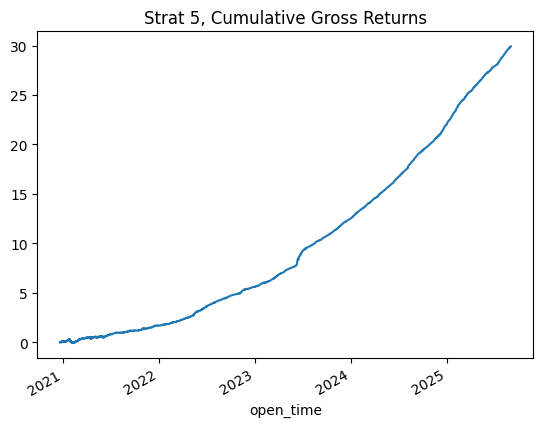

In [110]:
gross_returns.cumsum().plot(title="Strat 5, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 5, Benchmark, De-Correlated Strat 5, \nCumulative Net Returns'}, xlabel='open_time'>

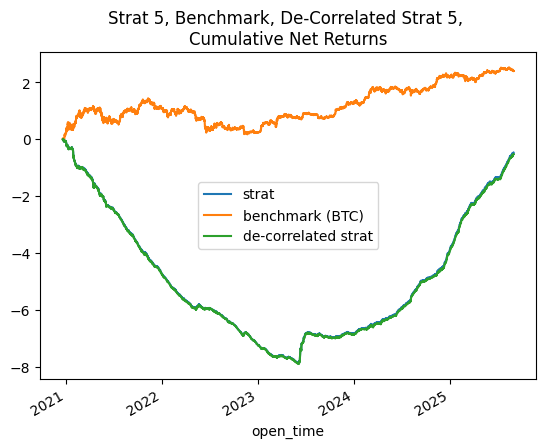

In [111]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 5, Benchmark, De-Correlated Strat 5, \nCumulative Net Returns")

In [112]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': -0.09927073885454141,
 'volatility': 0.3044407351992944,
 'sharpe ratio': -0.32607574275353246,
 'max drawdown': -2607.789316731074,
 'max drawdown duration': 1713.0,
 'alpha_BTC': -5.023957258621621e-05,
 'beta_BTC': 0.021931670261215057}

# Strategy 6: One-Period (4h) Reversal Signal Traded Less Frequently Than One Period

In [119]:
ret = px / px.shift() - 1
raw_signal = ret * -1
transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

### Trade Every 8 Hours

In [120]:
weights_8h = transformed_signal[
    (transformed_signal.index.hour == 0) |
    (transformed_signal.index.hour == 8) |
    (transformed_signal.index.hour == 16)
]

prices_8h = px[(px.index.hour == 0) | (px.index.hour == 8) | (px.index.hour == 16)]

gross_returns, net_returns = get_gross_returns_and_net_returns(weights_8h, prices_8h)

<Axes: title={'center': 'Strat 6, Trade Every 8 Hours, Cumulative Gross Returns'}, xlabel='open_time'>

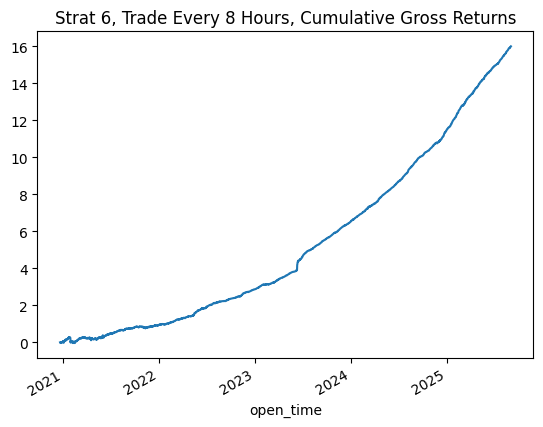

In [121]:
gross_returns.cumsum().plot(title="Strat 6, Trade Every 8 Hours, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 6, Trade Every 8 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns'}, xlabel='open_time'>

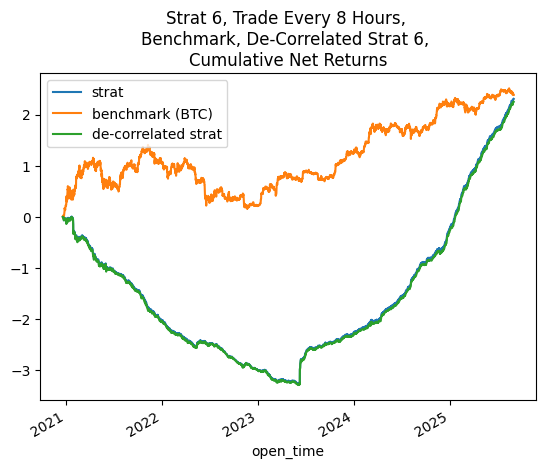

In [125]:
rets_8h = prices_8h / prices_8h.shift() - 1
bitcoin_8h_benchmark_rets = rets_8h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_8h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_8h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 6, Trade Every 8 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns")

In [126]:
get_strategy_stats(net_returns, 8, prices_8h)

{'avg returns': 0.4907906958582843,
 'volatility': 0.27573896021987393,
 'sharpe ratio': 1.7799105917674032,
 'max drawdown': -681.3019871423812,
 'max drawdown duration': 1457.3333333333333,
 'alpha_BTC': 0.0004378963629094422,
 'beta_BTC': 0.023539419257613263}

### Trade Every 12 Hours

In [127]:
weights_12h = transformed_signal[
    (transformed_signal.index.hour == 0) |
    (transformed_signal.index.hour == 12)
]

prices_12h = px[(px.index.hour == 0) | (px.index.hour == 12)]

gross_returns, net_returns = get_gross_returns_and_net_returns(weights_12h, prices_12h)

<Axes: title={'center': 'Strat 6, Trade Every 12 Hours, Cumulative Gross Returns'}, xlabel='open_time'>

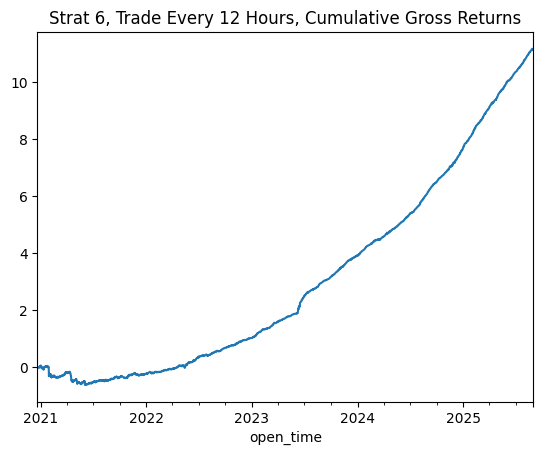

In [128]:
gross_returns.cumsum().plot(title="Strat 6, Trade Every 12 Hours, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 6, Trade Every 12 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns'}, xlabel='open_time'>

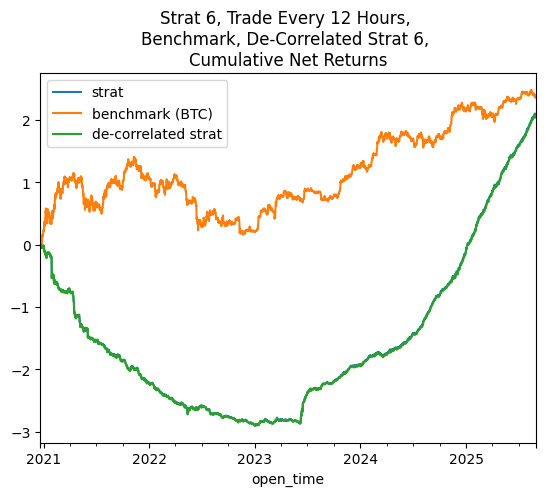

In [129]:
rets_12h = prices_12h / prices_12h.shift() - 1
bitcoin_12h_benchmark_rets = rets_12h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_12h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_12h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 6, Trade Every 12 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns")

In [130]:
get_strategy_stats(net_returns, 12, prices_12h)

{'avg returns': 0.4433270543245187,
 'volatility': 0.2733435696679309,
 'sharpe ratio': 1.621867508583029,
 'max drawdown': -0.3113875498601236,
 'max drawdown duration': 1476.0,
 'alpha_BTC': 0.000602263392392893,
 'beta_BTC': 0.008747909076329325}

### Trade Every 24 Hours

In [131]:
weights_24h = transformed_signal[
    transformed_signal.index.hour == 0
]

prices_24h = px[px.index.hour == 0]

gross_returns, net_returns = get_gross_returns_and_net_returns(weights_24h, prices_24h)

<Axes: title={'center': 'Strat 6, Trade Every 24 Hours, Cumulative Gross Returns'}, xlabel='open_time'>

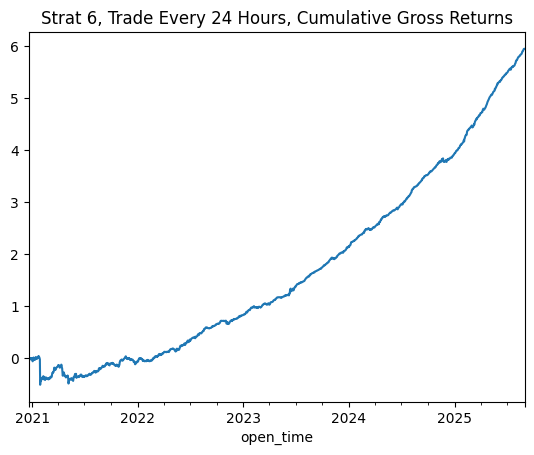

In [132]:
gross_returns.cumsum().plot(title="Strat 6, Trade Every 24 Hours, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 6, Trade Every 24 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns'}, xlabel='open_time'>

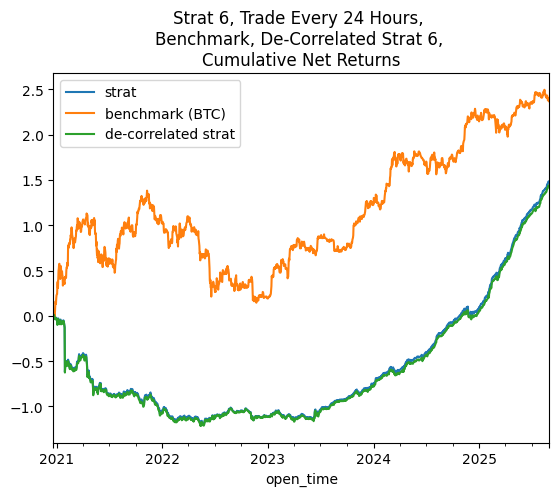

In [133]:
rets_24h = prices_24h / prices_24h.shift() - 1
bitcoin_24h_benchmark_rets = rets_24h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_24h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_24h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 6, Trade Every 24 Hours, \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns")

In [134]:
get_strategy_stats(net_returns, 24, prices_24h)

{'avg returns': 0.31478775595136693,
 'volatility': 0.3148278881113717,
 'sharpe ratio': 0.9998725266676802,
 'max drawdown': -106.50197712231366,
 'max drawdown duration': 1406.0,
 'alpha_BTC': 0.0008388165966022469,
 'beta_BTC': 0.018811836006039626}

# Strategy 7: Multiple-Period Reversal Signal Traded Less Frequently Than One Period

### Two Periods (8h frequency)

In [135]:
prices_8h = px[(px.index.hour == 0) | (px.index.hour == 8) | (px.index.hour == 16)]

ret = prices_8h / prices_8h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [136]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_8h)

<Axes: title={'center': 'Strat 7, Two Periods (8h Freq), Cumulative Gross Returns'}, xlabel='open_time'>

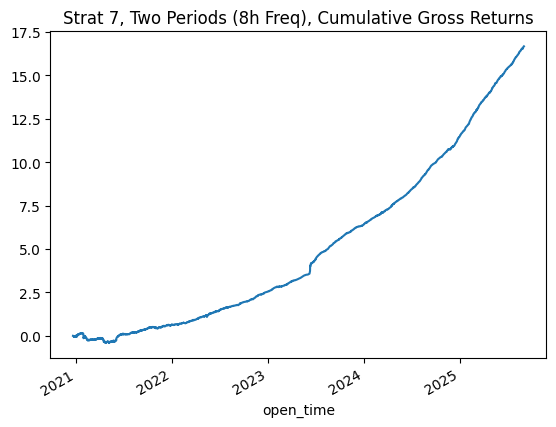

In [137]:
gross_returns.cumsum().plot(title="Strat 7, Two Periods (8h Freq), Cumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Two Periods (8h Freq), \nBenchmark, De-Correlated Strat 6, \nCumulative Net Returns'}, xlabel='open_time'>

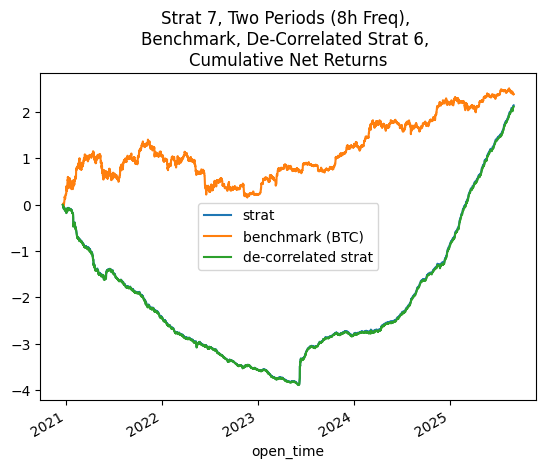

In [138]:
rets_8h = prices_8h / prices_8h.shift() - 1
bitcoin_8h_benchmark_rets = rets_8h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_8h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_8h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Two Periods (8h Freq), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [139]:
get_strategy_stats(net_returns, 8, prices_8h)

{'avg returns': 0.45620268171155387,
 'volatility': 0.28011090417334766,
 'sharpe ratio': 1.6286502057386212,
 'max drawdown': -0.2562911109121253,
 'max drawdown duration': 1531.6666666666667,
 'alpha_BTC': 0.0004118586751560859,
 'beta_BTC': 0.011503252316157508}

### Three Periods (12h frequency)

In [140]:
prices_12h = px[(px.index.hour == 0) | (px.index.hour == 12)]

ret = prices_12h / prices_12h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [141]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_12h)

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), \nCumulative Gross Returns'}, xlabel='open_time'>

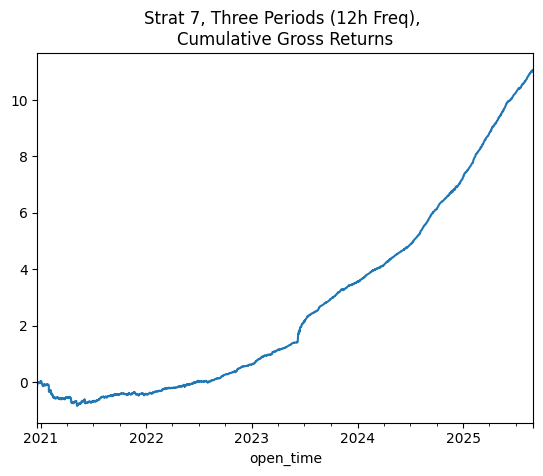

In [143]:
gross_returns.cumsum().plot(title="Strat 7, Three Periods (12h Freq), \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

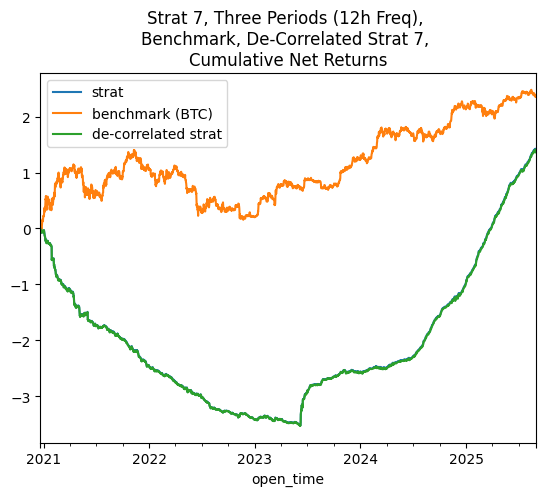

In [144]:
rets_12h = prices_12h / prices_12h.shift() - 1
bitcoin_12h_benchmark_rets = rets_12h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_12h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_12h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Three Periods (12h Freq), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [145]:
get_strategy_stats(net_returns, 12, prices_12h)

{'avg returns': 0.30329867084434486,
 'volatility': 0.27751087330391266,
 'sharpe ratio': 1.0929253590441879,
 'max drawdown': -1.8073860670379518,
 'max drawdown duration': 1557.0,
 'alpha_BTC': 0.0004116054202603098,
 'beta_BTC': 0.006882113031835971}

### Two Periods (8h frequency), 4h offset

In [146]:
prices_8h = px[(px.index.hour == 4) | (px.index.hour == 12) | (px.index.hour == 20)]

ret = prices_8h / prices_8h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [147]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_8h)

<Axes: title={'center': 'Strat 7, Two Periods (8h Freq), 4h Offset, \nCumulative Gross Returns'}, xlabel='open_time'>

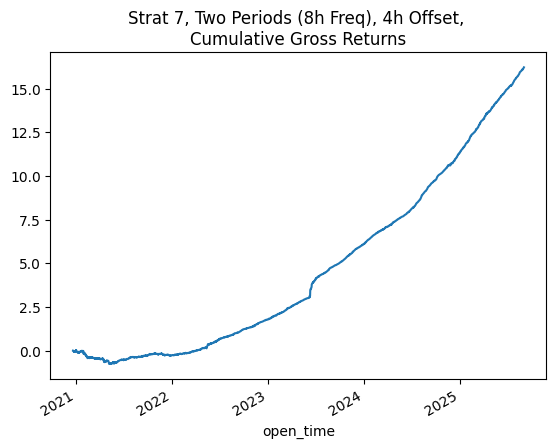

In [149]:
gross_returns.cumsum().plot(title="Strat 7, Two Periods (8h Freq), 4h Offset, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Two Periods (8h Freq), 4h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

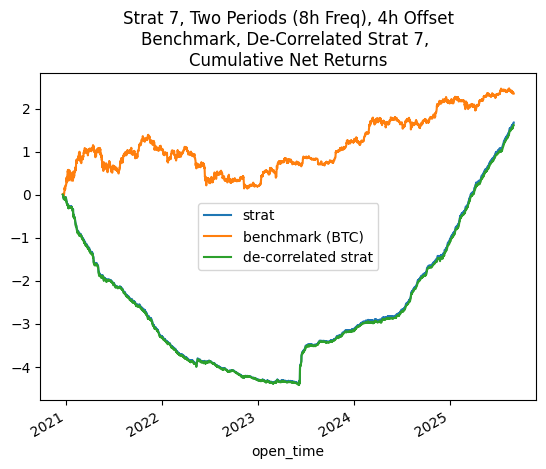

In [150]:
rets_8h = prices_8h / prices_8h.shift() - 1
bitcoin_8h_benchmark_rets = rets_8h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_8h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_8h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Two Periods (8h Freq), 4h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [151]:
get_strategy_stats(net_returns, 8, prices_8h)

{'avg returns': 0.35637291288139594,
 'volatility': 0.2716336551008287,
 'sharpe ratio': 1.311961556270016,
 'max drawdown': -0.38669375024699904,
 'max drawdown duration': 1551.3333333333333,
 'alpha_BTC': 0.00031502616327939526,
 'beta_BTC': 0.02410284690555245}

### Three Periods (12h frequency), 4h offset

In [152]:
prices_12h = px[(px.index.hour == 4) | (px.index.hour == 16)]

ret = prices_12h / prices_12h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [153]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_12h)

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), 4h Offset, \nCumulative Gross Returns'}, xlabel='open_time'>

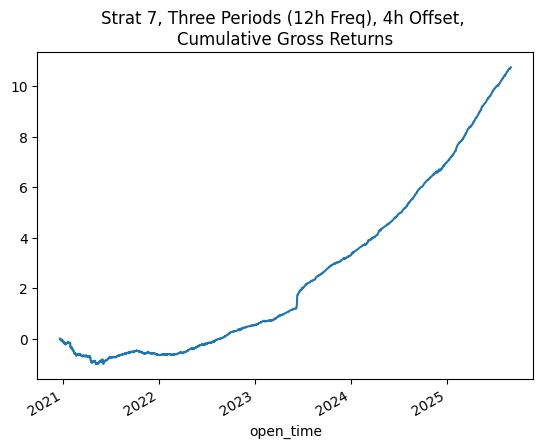

In [156]:
gross_returns.cumsum().plot(title="Strat 7, Three Periods (12h Freq), 4h Offset, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), 4h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

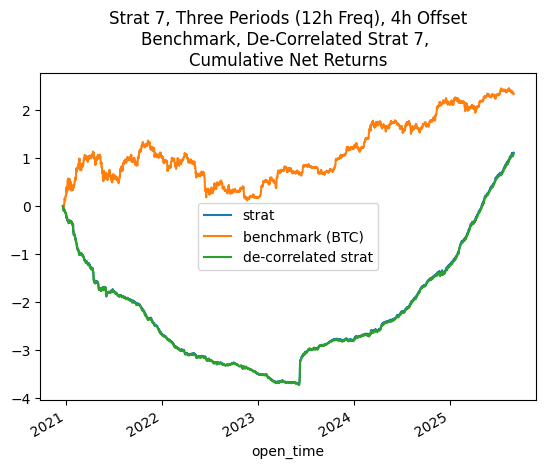

In [157]:
rets_12h = prices_12h / prices_12h.shift() - 1
bitcoin_12h_benchmark_rets = rets_12h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_12h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_12h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Three Periods (12h Freq), 4h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [158]:
get_strategy_stats(net_returns, 12, prices_12h)

{'avg returns': 0.23777865102834142,
 'volatility': 0.26326051844969267,
 'sharpe ratio': 0.9032066503119774,
 'max drawdown': -0.12922735669713248,
 'max drawdown duration': 1592.5,
 'alpha_BTC': 0.00031709958711150155,
 'beta_BTC': 0.013812174785348201}

### Three Periods (12h Frequency), 8h offset

In [138]:
prices_12h = px[(px.index.hour == 8) | (px.index.hour == 20)]

ret = prices_12h / prices_12h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [139]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_12h)

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), 8h Offset, \nCumulative Gross Returns'}, xlabel='open_time'>

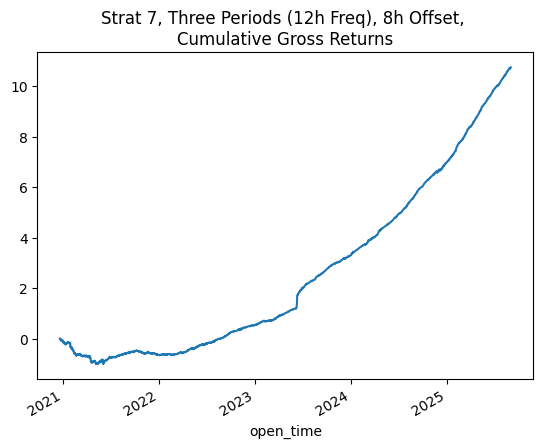

In [160]:
gross_returns.cumsum().plot(title="Strat 7, Three Periods (12h Freq), 8h Offset, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Three Periods (12h Freq), 8h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

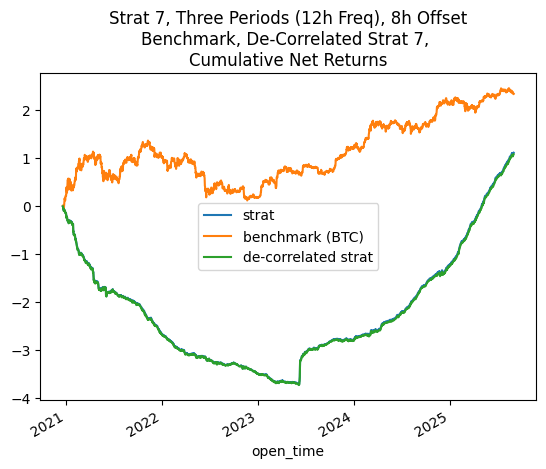

In [162]:
rets_12h = prices_12h / prices_12h.shift() - 1
bitcoin_12h_benchmark_rets = rets_12h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_12h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_12h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Three Periods (12h Freq), 8h Offset\nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [163]:
get_strategy_stats(net_returns, 12, prices_12h)

{'avg returns': 0.23777865102834142,
 'volatility': 0.26326051844969267,
 'sharpe ratio': 0.9032066503119774,
 'max drawdown': -0.12922735669713248,
 'max drawdown duration': 1592.5,
 'alpha_BTC': 0.00031709958711150155,
 'beta_BTC': 0.013812174785348201}

### Six Periods (24h Frequency)

In [164]:
prices_24h = px[px.index.hour == 0]

ret = prices_24h / prices_24h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [165]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_24h)

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), \nCumulative Gross Returns'}, xlabel='open_time'>

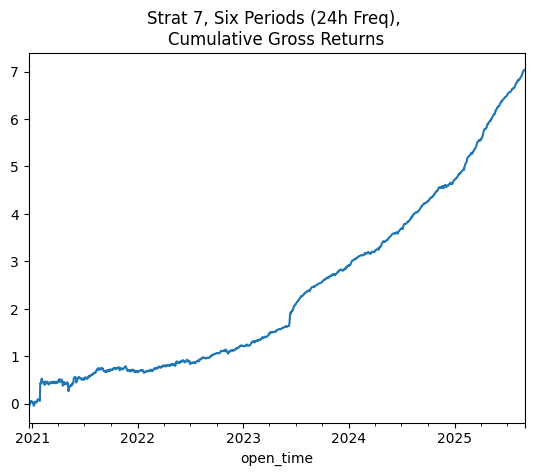

In [166]:
gross_returns.cumsum().plot(title="Strat 7, Six Periods (24h Freq), \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

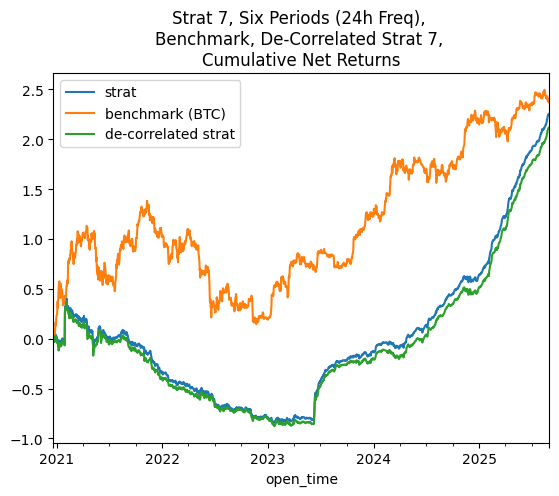

In [167]:
rets_24h = prices_24h / prices_24h.shift() - 1
bitcoin_24h_benchmark_rets = rets_24h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_24h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_24h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Six Periods (24h Freq), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [168]:
get_strategy_stats(net_returns, 24, prices_24h)

{'avg returns': 0.4799681950090557,
 'volatility': 0.276879003868989,
 'sharpe ratio': 1.733494372278811,
 'max drawdown': -3.6885976834774485,
 'max drawdown duration': 1313.0,
 'alpha_BTC': 0.0012380505616458386,
 'beta_BTC': 0.05808818287611552}

### Six Periods (24h Frequency), Offset 8h

In [169]:
prices_24h = px[px.index.hour == 8]

ret = prices_24h / prices_24h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [170]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_24h)

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), Offset 8h, \nCumulative Gross Returns'}, xlabel='open_time'>

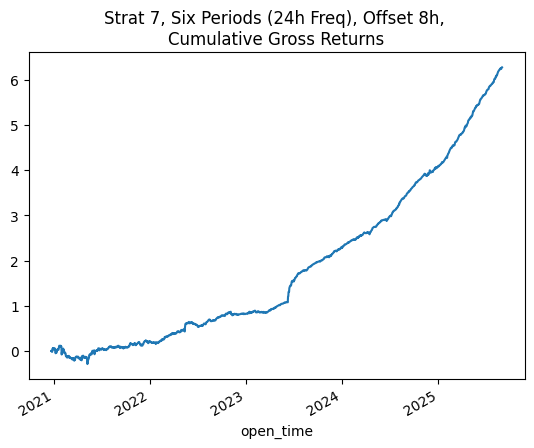

In [171]:
gross_returns.cumsum().plot(title="Strat 7, Six Periods (24h Freq), Offset 8h, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), 8h Offset, \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

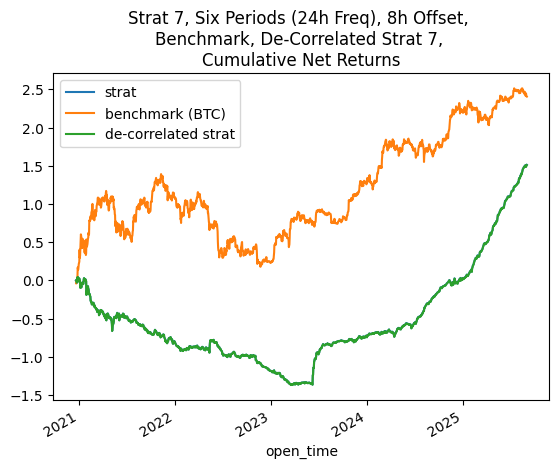

In [172]:
rets_24h = prices_24h / prices_24h.shift() - 1
bitcoin_24h_benchmark_rets = rets_24h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_24h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_24h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Six Periods (24h Freq), 8h Offset, \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [173]:
get_strategy_stats(net_returns, 24, prices_24h)

{'avg returns': 0.32185785319020044,
 'volatility': 0.2531363248333716,
 'sharpe ratio': 1.2714803116544617,
 'max drawdown': -34.09252102696366,
 'max drawdown duration': 1472.0,
 'alpha_BTC': 0.0008819578875841319,
 'beta_BTC': 0.001431275738542683}

### Six Periods (24h Frequency), Offset 12h

In [174]:
prices_24h = px[px.index.hour == 12]

ret = prices_24h / prices_24h.shift() - 1
raw_signal = ret * -1

transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

In [175]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, prices_24h)

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), Offset 12h, \nCumulative Gross Returns'}, xlabel='open_time'>

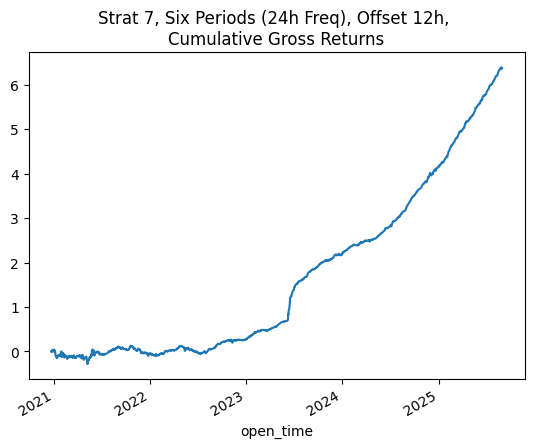

In [176]:
gross_returns.cumsum().plot(title="Strat 7, Six Periods (24h Freq), Offset 12h, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 7, Six Periods (24h Freq), Offset (12h), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns'}, xlabel='open_time'>

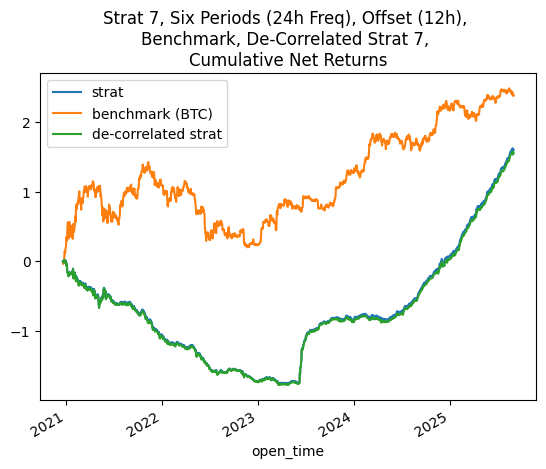

In [177]:
rets_24h = prices_24h / prices_24h.shift() - 1
bitcoin_24h_benchmark_rets = rets_24h['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_24h_benchmark_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_24h_benchmark_rets)
})

graph_df.cumsum().plot(title = "Strat 7, Six Periods (24h Freq), Offset (12h), \nBenchmark, De-Correlated Strat 7, \nCumulative Net Returns")

In [178]:
get_strategy_stats(net_returns, 24, prices_24h)

{'avg returns': 0.3409970623041058,
 'volatility': 0.26633977748901005,
 'sharpe ratio': 1.280308429776984,
 'max drawdown': -81.84902295902238,
 'max drawdown duration': 1434.0,
 'alpha_BTC': 0.000909845405385501,
 'beta_BTC': 0.018872341591304104}

# Strategy 8: Use Raw One-Period (4h) Reversal Signal (Don't Rank But Do Demean-Normalize)

In [179]:
ret = px / px.shift() - 1
raw_signal = ret * -1
transformed_signal = get_demeaned_normalized_signal(raw_signal)

In [180]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)

<Axes: title={'center': 'Strat 8, Cumulative Gross Returns'}, xlabel='open_time'>

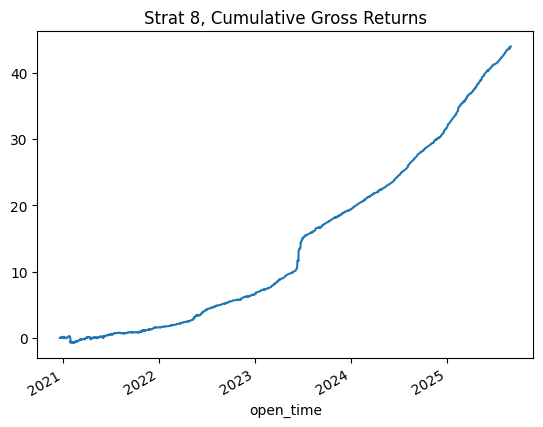

In [181]:
gross_returns.cumsum().plot(title="Strat 8, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 8, Benchmark, De-Correlated Strat 8, \nCumulative Net Returns'}, xlabel='open_time'>

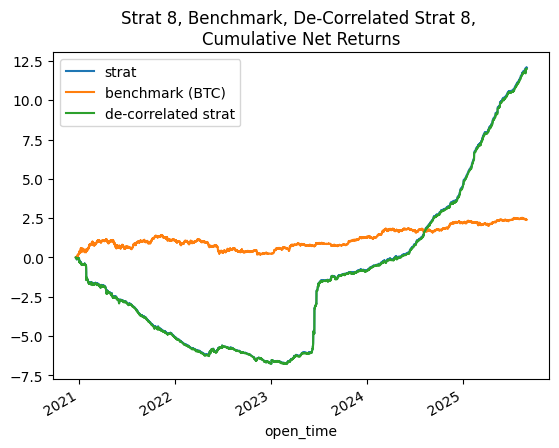

In [183]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": ret['BTCUSDT'],
    "de-correlated strat": get_decorrelated_returns(net_returns, ret['BTCUSDT'])
})

graph_df.cumsum().plot(title = "Strat 8, Benchmark, De-Correlated Strat 8, \nCumulative Net Returns")

In [184]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 2.5719698716189514,
 'volatility': 1.0091196900201524,
 'sharpe ratio': 2.548726278017218,
 'max drawdown': -2.095101459591535,
 'max drawdown duration': 1212.8333333333333,
 'alpha_BTC': 0.0011671827414081214,
 'beta_BTC': 0.0329462839815709}

# Strategy 9: Multiple-Period Reversal Signal Traded Every Period

### Price Change Over 8 Hours

In [185]:
ret = px / px.shift(2) - 1
raw_signal = -1 * ret
transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00    0.000000
2020-12-20 08:00:00   -0.002000
2020-12-20 12:00:00   -0.006960
2020-12-20 16:00:00   -0.001425
                         ...   
2025-08-30 16:00:00    0.004055
2025-08-30 20:00:00    0.001682
2025-08-31 00:00:00    0.000036
2025-08-31 04:00:00    0.001867
2025-08-31 08:00:00   -0.002286
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 9, Price Change Every 8 Hours, \nCumulative Gross Returns'}, xlabel='open_time'>

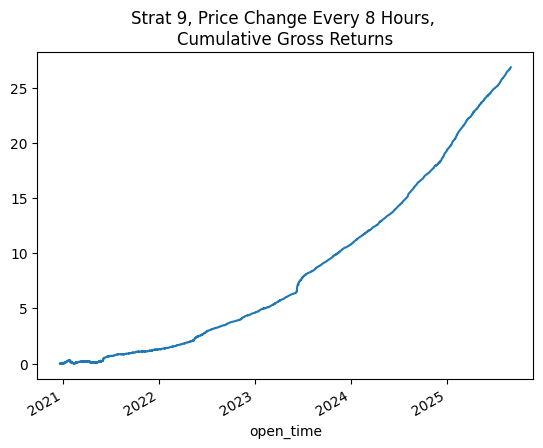

In [186]:
gross_returns.cumsum().plot(title="Strat 9, Price Change Every 8 Hours, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 9, Price Change Every 8 Hours, \nBenchmark, De-Correlated Strat 9, \nCumulative Net Returns'}, xlabel='open_time'>

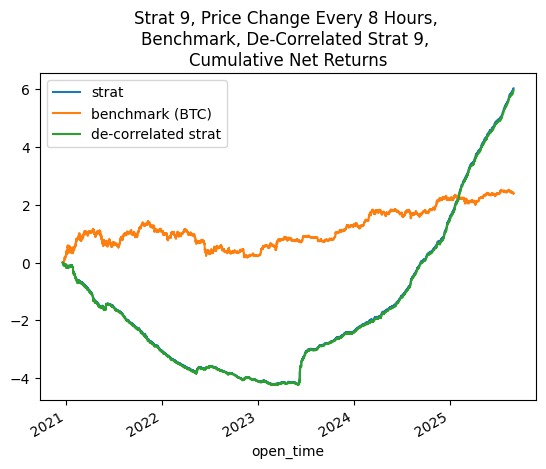

In [187]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 9, Price Change Every 8 Hours, \nBenchmark, De-Correlated Strat 9, \nCumulative Net Returns")

In [188]:
get_strategy_stats(net_returns, 4, px)

{'avg returns': 1.2846476576733588,
 'volatility': 0.29705483855829473,
 'sharpe ratio': 4.324614485016229,
 'max drawdown': -0.20614532393703922,
 'max drawdown duration': 1360.5,
 'alpha_BTC': 0.0005799394808280856,
 'beta_BTC': 0.02914293379730194}

### Price Change Over 12 Hours

In [189]:
ret = px / px.shift(3) - 1
raw_signal = -1 * ret
transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
net_returns

open_time
2020-12-20 00:00:00    0.000000
2020-12-20 04:00:00    0.000000
2020-12-20 08:00:00    0.000000
2020-12-20 12:00:00   -0.002000
2020-12-20 16:00:00    0.000650
                         ...   
2025-08-30 16:00:00    0.006626
2025-08-30 20:00:00    0.001749
2025-08-31 00:00:00    0.003672
2025-08-31 04:00:00    0.003141
2025-08-31 08:00:00   -0.000958
Length: 10291, dtype: float64

<Axes: title={'center': 'Strat 9, Price Change Every 12 Hours, \nCumulative Gross Returns'}, xlabel='open_time'>

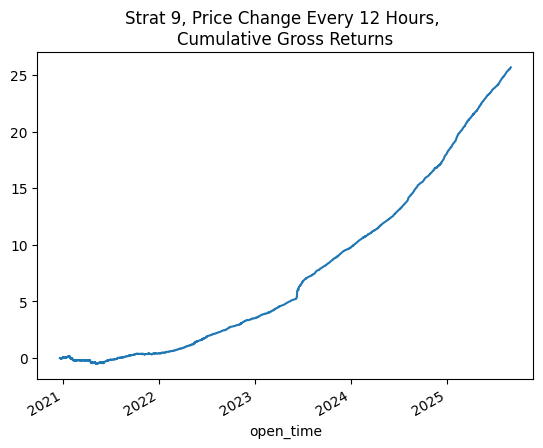

In [190]:
gross_returns.cumsum().plot(title="Strat 9, Price Change Every 12 Hours, \nCumulative Gross Returns")

<Axes: title={'center': 'Strat 9, Price Change Every 12 Hours, \nBenchmark, De-Correlated Strat 9, \nCumulative Net Returns'}, xlabel='open_time'>

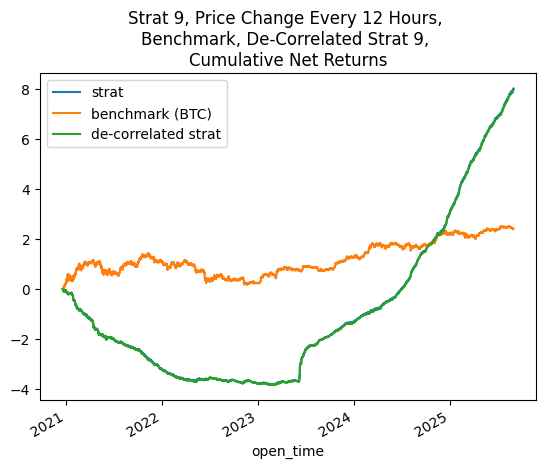

In [191]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 9, Price Change Every 12 Hours, \nBenchmark, De-Correlated Strat 9, \nCumulative Net Returns")

In [192]:
pd.Series(get_strategy_stats(net_returns, 4, px))

avg returns                 1.705058
volatility                  0.298618
sharpe ratio                5.709832
max drawdown               -0.594178
max drawdown duration    1285.833333
alpha_BTC                   0.000774
beta_BTC                    0.020163
dtype: float64

# Strategy 10: Winsorize Un-ranked Demean-Normalized Reversal Signal

In [193]:
rets = px / px.shift() - 1
raw_signal = rets * -1
transformed_signal = get_demeaned_normalized_signal(raw_signal)

### Winsorize Top And Bottom 2%

In [194]:
winsorized_signal = get_winsorized_signal(transformed_signal, 0.02, 0.02)
gross_returns, net_returns = get_gross_returns_and_net_returns(winsorized_signal, px)

<Axes: title={'center': 'Strat 10, Top And Bottom 2%, Cumulative Gross Returns'}, xlabel='open_time'>

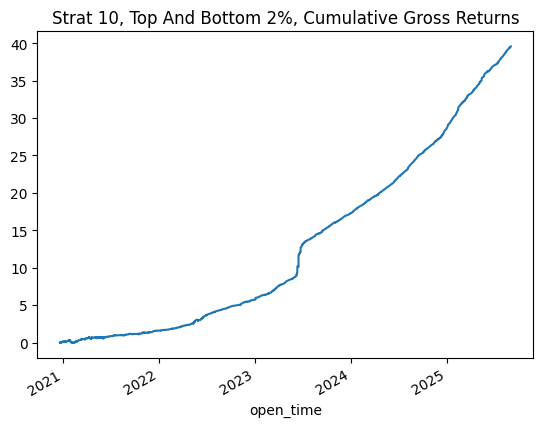

In [195]:
gross_returns.cumsum().plot(title="Strat 10, Top And Bottom 2%, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 10, Top And Bottom 2%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns'}, xlabel='open_time'>

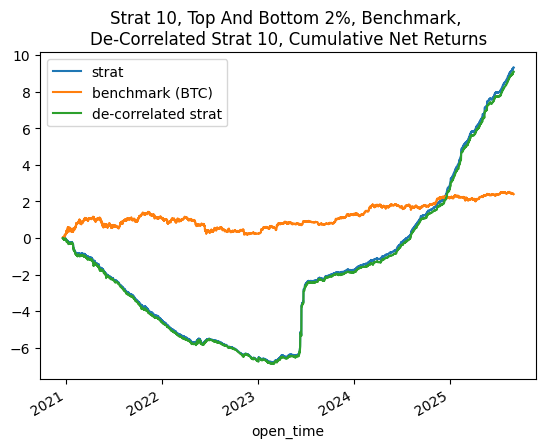

In [197]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 10, Top And Bottom 2%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns")

In [198]:
pd.Series(get_strategy_stats(net_returns, 4, px))

avg returns                 1.987124
volatility                  0.920843
sharpe ratio                2.157939
max drawdown            -2175.164322
max drawdown duration    1308.500000
alpha_BTC                   0.000886
beta_BTC                    0.095201
dtype: float64

### Winsorize Top And Bottom 5%

In [199]:
winsorized_signal = get_winsorized_signal(transformed_signal, 0.05, 0.05)
gross_returns, net_returns = get_gross_returns_and_net_returns(winsorized_signal, px)

<Axes: title={'center': 'Strat 10, Top And Bottom 5%, Cumulative Gross Returns'}, xlabel='open_time'>

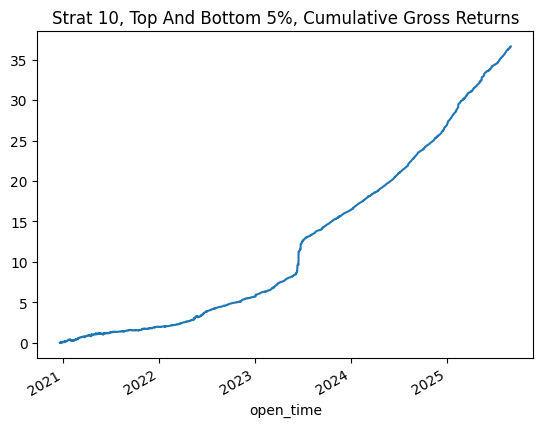

In [200]:
gross_returns.cumsum().plot(title="Strat 10, Top And Bottom 5%, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 10, Top And Bottom 5%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns'}, xlabel='open_time'>

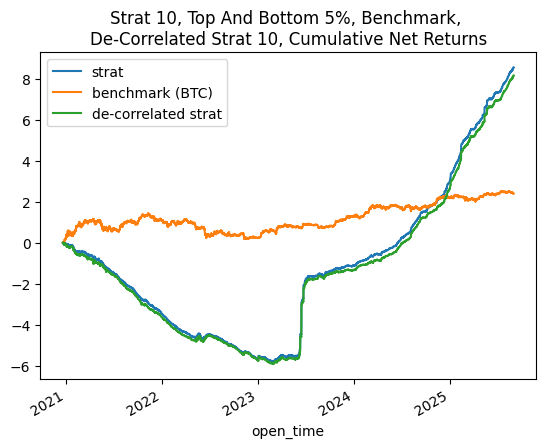

In [201]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 10, Top And Bottom 5%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns")

In [202]:
pd.Series(get_strategy_stats(net_returns, 4, px))

avg returns                 1.818046
volatility                  0.903771
sharpe ratio                2.011622
max drawdown             -641.090906
max drawdown duration    1274.166667
alpha_BTC                   0.000793
beta_BTC                    0.163364
dtype: float64

### Winsorize Top And Bottom 10%

In [203]:
winsorized_signal = get_winsorized_signal(transformed_signal, 0.10, 0.10)
gross_returns, net_returns = get_gross_returns_and_net_returns(winsorized_signal, px)

<Axes: title={'center': 'Strat 10, Top And Bottom 10%, Cumulative Gross Returns'}, xlabel='open_time'>

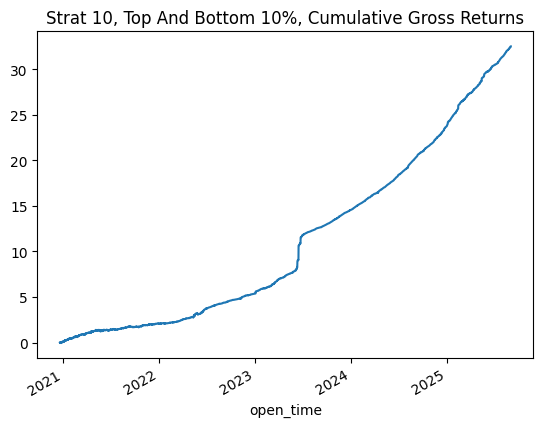

In [204]:
gross_returns.cumsum().plot(title="Strat 10, Top And Bottom 10%, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 10, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns'}, xlabel='open_time'>

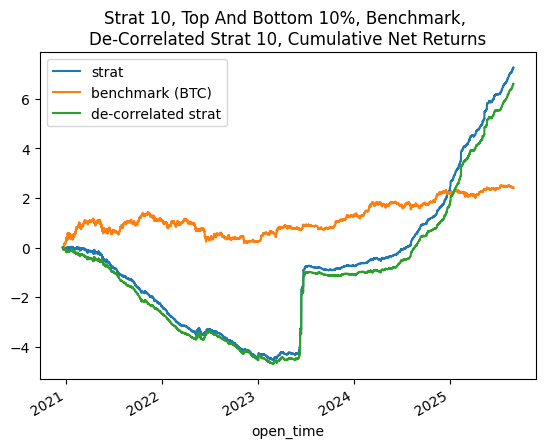

In [205]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 10, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns")

In [206]:
pd.Series(get_strategy_stats(net_returns, 4, px))

avg returns                 1.546494
volatility                  0.905297
sharpe ratio                1.708272
max drawdown             -152.742206
max drawdown duration    1274.833333
alpha_BTC                   0.000643
beta_BTC                    0.271977
dtype: float64

### Winsorize Top And Bottom 20%

In [207]:
winsorized_signal = get_winsorized_signal(transformed_signal, 0.20, 0.20)
gross_returns, net_returns = get_gross_returns_and_net_returns(winsorized_signal, px)

<Axes: title={'center': 'Strat 10, Top And Bottom 20%, Cumulative Gross Returns'}, xlabel='open_time'>

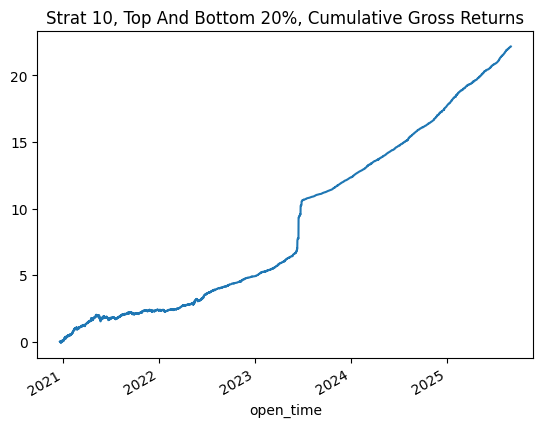

In [208]:
gross_returns.cumsum().plot(title="Strat 10, Top And Bottom 20%, Cumulative Gross Returns")

<Axes: title={'center': 'Strat 10, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns'}, xlabel='open_time'>

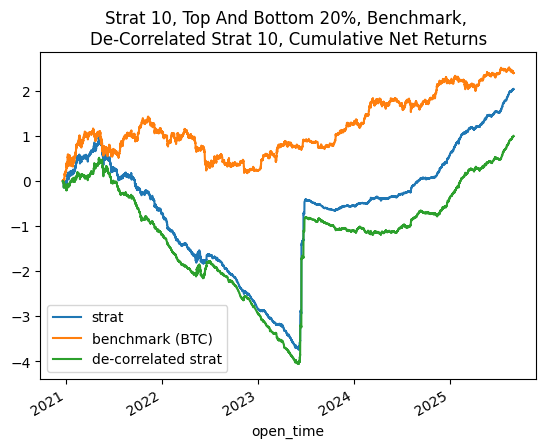

In [209]:
benchmark_ret = px / px.shift() - 1
bitcoin_benchmark_ret = benchmark_ret['BTCUSDT']

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_ret,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_ret)
})

graph_df.cumsum().plot(title = "Strat 10, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 10, Cumulative Net Returns")

In [210]:
pd.Series(get_strategy_stats(net_returns, 4, px))

avg returns                 0.435252
volatility                  0.896885
sharpe ratio                0.485293
max drawdown              -15.344705
max drawdown duration    1375.000000
alpha_BTC                   0.000098
beta_BTC                    0.434048
dtype: float64